# Ephemeris object imaging: continuum (mosaic gridder) with the relative path to the attached ephemeris table

This nootebook demonstlates continuum imaging of the ephemeris objects. 
Use relative path to the attached ephemeris table to verify recent bug fix.

In the following steps first we use the attached ephemeris table(s).

In [1]:
# extra packages needed
#import os
#!pip install astropy
#!pip install aplpy'

In [2]:
# install ipynb module to reuse other notebook's functions
#!pip install ipynb

In [3]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

In [4]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

## Imaging with epehemeris data attached to the MS by directly specifying the internal table in the <u> relative path </u> for stopping the source
In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. This demo shows one can explicitly specify the path of the internal ephemeris table in the phasecenter parameter. The result should be the same as phasecenter='TRACKFIELD' case.

In [5]:
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [6]:
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [7]:
imgname='Venus-mosaic-mfs-relpathIntab'

In [8]:
delete_tcleanimages(imgname)

In [9]:
# relative path for the ephemeris table
ephemtab = 'venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab'

In [10]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[480,432], 
           cell=['0.14arcsec'], phasecenter=ephemtab, specmode='mfs', gridder='mosaic', 
           usepointing=True, niter=100)
ret['iterdone']

100

### Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [11]:
# Get the first time stamp recorded in the image
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
iminfo['date-obs']

# find the direction of Venus 
ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'], 'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.684e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.642e+00 [aplpy.core]
ky=ineph
ineph at: 15:57:28.746, -016.57.50.059
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

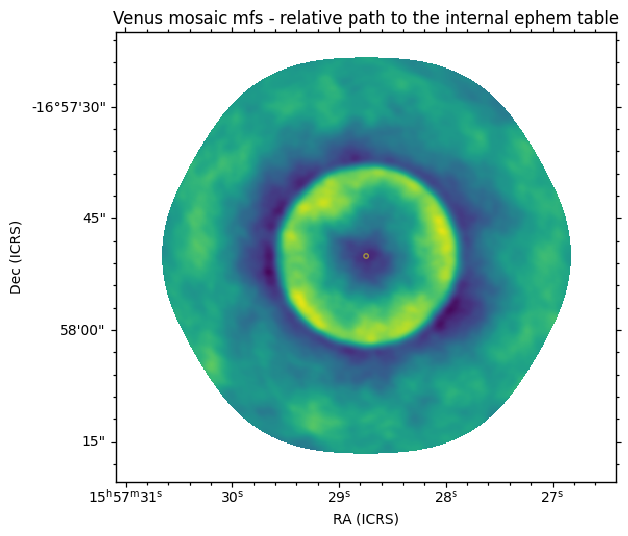

In [12]:
displayImage(imgname+'.image', markers=inephmarker, 
             title='Venus mosaic mfs - relative path to the internal ephem table')

The center of the image and the position from the internal ephemeris table agree and the source appears at the center of the image.

In [13]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
#print("external ephem dir = ",qa.time(external_ephem_dir['m0'],prec=9),qa.angle(internal_ephem_dir['m1'],prec=9))

internal ephem dir =  ['15:57:28.746'] ['-016.57.50.059']


In [14]:
printImageCenter(imgname+'.image')

('15:57:28.746', '-016.57.50.059')

In [15]:
# positoin from the default ephemeris data in data repo
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch('utc',iminfo['date-obs']))
ve_dir=me.measure(me.measure(me.direction('Venus'),'AZELGEO'),'ICRS')
print("Venus position by Measures data:",qa.time(ve_dir['m0'],prec=9),qa.angle(ve_dir['m1'],prec=9))

Venus position by Measures data: ['15:57:28.543'] ['-016.57.49.411']
